In [ ]:
# 00_load_synthetic_data.py
import numpy as np, pandas as pd, os
clean.write.mode("overwrite").parquet("data/curated/")
np.random.seed(42)

# ---- Parameters: scale up freely ----
start = pd.Timestamp("2023-01-01")   # set to "1990-01-01" to reach 10M+ rows
end   = pd.Timestamp("2024-12-31")
categories = ["Footwear","Apparel","Accessories"]
channels   = ["Online","Store","Outlet"]
base_price = {"Footwear":120.0,"Apparel":60.0,"Accessories":30.0}
base_demand= {"Footwear":200,   "Apparel":300,  "Accessories":400}

# ---- Calendar + global signals ----
cal = pd.date_range(start, end, freq="D")
cdf = pd.DataFrame({"date":cal})
n = len(cdf); t = np.arange(n)
cdf["dow"]    = cdf["date"].dt.dayofweek
cdf["month"]  = cdf["date"].dt.month
cdf["year"]   = cdf["date"].dt.year
cdf["market_index"] = 1.0 + 0.15*np.sin(2*np.pi*t/365.25) + 0.05*np.random.randn(n)
liq = np.cumsum(np.random.normal(0,0.02,n))
cdf["liquidity"] = (liq - liq.min())/(liq.max()-liq.min())
cdf["turnover"]  = 1.0 + 0.10*np.cos(2*np.pi*t/90) + 0.05*np.random.randn(n)

# ---- Expand over category × channel and simulate demand ----
rows=[]
for cat in categories:
    for ch in channels:
        df=cdf.copy()
        # prices (channel adjustments)
        bp = base_price[cat]*(1.0 + (0.05 if ch=="Online" else 0.0) - (0.05 if ch=="Outlet" else 0.0))
        df["base_price"]=bp
        # liquidity → discount bands
        low  = df["liquidity"]<0.4
        med  = (df["liquidity"]>=0.4)&(df["liquidity"]<0.7)
        high = df["liquidity"]>=0.7
        disc = np.zeros(len(df))
        disc[low]  = np.random.uniform(0.17,0.19,low.sum())
        disc[med]  = np.random.uniform(0.19,0.22,med.sum())
        disc[high] = np.random.uniform(0.22,0.24,high.sum())
        disc += np.random.normal(0,0.003,len(df))
        disc = np.clip(disc,0,0.50)
        df["discount_rate"]=disc
        df["price"]=df["base_price"]*(1-df["discount_rate"])

        # demand with diminishing returns: 1+a*d-b*d^2 (optimum ~20–22%)
        a,b = 1.0, 2.2
        disc_mult = 1 + a*df["discount_rate"] - b*(df["discount_rate"]**2)
        week_mult = 1 + 0.08*(df["dow"]>=5)            # weekend
        month_mult= 1 + 0.10*(df["month"].isin([8,9,11,12])) # peaks
        exog_mult = df["market_index"]*(1+0.05*(df["turnover"]-df["turnover"].mean()))
        base_d = base_demand[cat]*(1.0 + (0.10 if ch=="Online" else -0.05 if ch=="Outlet" else 0.0))
        lam = base_d*disc_mult*week_mult*month_mult*exog_mult
        qty = np.maximum(0, np.round(np.random.lognormal(np.log(lam/100.0), 0.25)*100.0)).astype(int)

        df["category"]=cat; df["channel"]=ch
        df["quantity_sold"]=qty
        df["revenue"]=df["price"]*df["quantity_sold"]
        rows.append(df)

full = pd.concat(rows, ignore_index=True)
os.makedirs("data", exist_ok=True)
full.to_csv("data/adidas_daily.csv", index=False)
print("Saved data/adidas_daily.csv with", len(full), "rows")

Saved data/adidas_daily.csv with 6579 rows


In [ ]:
# 1_ingest_clean_to_bronze_silver.py
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder.appName("AdidasIngestClean").getOrCreate()

# Read generated CSV
df = (spark.read.option("header",True).option("inferSchema",True)
      .csv("data/adidas_daily.csv"))

# Basic casting (extend with real validation rules as needed)
clean = (df
  .withColumn("date", col("date").cast("date"))
  .withColumn("quantity_sold", col("quantity_sold").cast("int"))
  .withColumn("revenue", col("revenue").cast("double"))
  .filter(col("discount_rate").between(0,0.9))
  .filter(col("price")>0)
)

# Write curated Parquet → HDFS (Silver)
(clean
 .withColumn("year", col("year").cast("int"))
 .repartition("year","category")
 .write.mode("overwrite")
 .partitionBy("year","category")
 .parquet("hdfs:///projects/adidas/curated/daily/"))

print("Wrote curated Parquet to hdfs:///projects/adidas/curated/daily/")
``

SyntaxError: invalid syntax (ipython-input-4074176038.py, line 29)

In [ ]:
# 2_feature_engineering_to_gold.py
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import lag, avg, month, dayofweek, col

spark = SparkSession.builder.appName("AdidasFeatures").getOrCreate()

base = spark.read.parquet("hdfs:///projects/adidas/curated/daily/")

w = Window.partitionBy("category").orderBy("date")

feat = (base
  .withColumn("qty_lag_1",  lag("quantity_sold", 1).over(w))
  .withColumn("qty_lag_7",  lag("quantity_sold", 7).over(w))
  .withColumn("qty_lag_30", lag("quantity_sold",30).over(w))
  .withColumn("qty_ma_7",   avg("quantity_sold").over(w.rowsBetween(-6,0)))
  .withColumn("qty_ma_30",  avg("quantity_sold").over(w.rowsBetween(-29,0)))
  .withColumn("month",      month(col("date")))
  .withColumn("dow",        dayofweek(col("date")))
  .na.drop(subset=["qty_lag_1","qty_lag_7","qty_lag_30","qty_ma_7","qty_ma_30"])
)

(feat
 .repartition("year","category")
 .write.mode("overwrite")
 .partitionBy("year","category")
 .parquet("hdfs:///projects/adidas/features/daily/"))

print("Wrote features to hdfs:///projects/adidas/features/daily/")

Py4JJavaError: An error occurred while calling o84.parquet.
: java.io.IOException: Incomplete HDFS URI, no host: hdfs:///projects/adidas/curated/daily
	at org.apache.hadoop.hdfs.DistributedFileSystem.initialize(DistributedFileSystem.java:185)
	at org.apache.hadoop.fs.FileSystem.createFileSystem(FileSystem.java:3615)
	at org.apache.hadoop.fs.FileSystem.access$300(FileSystem.java:172)
	at org.apache.hadoop.fs.FileSystem$Cache.getInternal(FileSystem.java:3716)
	at org.apache.hadoop.fs.FileSystem$Cache.get(FileSystem.java:3667)
	at org.apache.hadoop.fs.FileSystem.get(FileSystem.java:557)
	at org.apache.hadoop.fs.Path.getFileSystem(Path.java:366)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$checkAndGlobPathIfNecessary$1(DataSource.scala:777)
	at scala.collection.immutable.List.map(List.scala:247)
	at scala.collection.immutable.List.map(List.scala:79)
	at org.apache.spark.sql.execution.datasources.DataSource$.checkAndGlobPathIfNecessary(DataSource.scala:775)
	at org.apache.spark.sql.execution.datasources.DataSource.checkAndGlobPathIfNecessary(DataSource.scala:575)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:419)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(ResolveDataSource.scala:143)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.$anonfun$applyOrElse$2(ResolveDataSource.scala:61)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.applyOrElse(ResolveDataSource.scala:61)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.applyOrElse(ResolveDataSource.scala:45)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:139)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:86)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:139)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:416)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:135)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:131)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp(AnalysisHelper.scala:112)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp$(AnalysisHelper.scala:111)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUp(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.apply(ResolveDataSource.scala:45)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.apply(ResolveDataSource.scala:43)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:242)
	at scala.collection.LinearSeqOps.foldLeft(LinearSeq.scala:183)
	at scala.collection.LinearSeqOps.foldLeft$(LinearSeq.scala:179)
	at scala.collection.immutable.List.foldLeft(List.scala:79)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:239)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:231)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:231)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:340)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:336)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:234)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:336)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:299)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:201)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:201)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.resolveInFixedPoint(HybridAnalyzer.scala:190)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.$anonfun$apply$1(HybridAnalyzer.scala:76)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.withTrackedAnalyzerBridgeState(HybridAnalyzer.scala:111)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.apply(HybridAnalyzer.scala:71)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:330)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:423)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:330)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$2(QueryExecution.scala:110)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:148)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:278)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:278)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:277)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$1(QueryExecution.scala:110)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
	at org.apache.spark.util.Utils$.getTryWithCallerStacktrace(Utils.scala:1439)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:121)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:80)
	at org.apache.spark.sql.classic.Dataset$.$anonfun$ofRows$1(Dataset.scala:115)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.classic.Dataset$.ofRows(Dataset.scala:113)
	at org.apache.spark.sql.classic.DataFrameReader.load(DataFrameReader.scala:109)
	at org.apache.spark.sql.classic.DataFrameReader.load(DataFrameReader.scala:58)
	at org.apache.spark.sql.DataFrameReader.parquet(DataFrameReader.scala:457)
	at org.apache.spark.sql.classic.DataFrameReader.parquet(DataFrameReader.scala:306)
	at org.apache.spark.sql.classic.DataFrameReader.parquet(DataFrameReader.scala:58)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)
	Suppressed: org.apache.spark.util.Utils$OriginalTryStackTraceException: Full stacktrace of original doTryWithCallerStacktrace caller
		at org.apache.hadoop.hdfs.DistributedFileSystem.initialize(DistributedFileSystem.java:185)
		at org.apache.hadoop.fs.FileSystem.createFileSystem(FileSystem.java:3615)
		at org.apache.hadoop.fs.FileSystem.access$300(FileSystem.java:172)
		at org.apache.hadoop.fs.FileSystem$Cache.getInternal(FileSystem.java:3716)
		at org.apache.hadoop.fs.FileSystem$Cache.get(FileSystem.java:3667)
		at org.apache.hadoop.fs.FileSystem.get(FileSystem.java:557)
		at org.apache.hadoop.fs.Path.getFileSystem(Path.java:366)
		at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$checkAndGlobPathIfNecessary$1(DataSource.scala:777)
		at scala.collection.immutable.List.map(List.scala:247)
		at scala.collection.immutable.List.map(List.scala:79)
		at org.apache.spark.sql.execution.datasources.DataSource$.checkAndGlobPathIfNecessary(DataSource.scala:775)
		at org.apache.spark.sql.execution.datasources.DataSource.checkAndGlobPathIfNecessary(DataSource.scala:575)
		at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:419)
		at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(ResolveDataSource.scala:143)
		at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.$anonfun$applyOrElse$2(ResolveDataSource.scala:61)
		at scala.Option.getOrElse(Option.scala:201)
		at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.applyOrElse(ResolveDataSource.scala:61)
		at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.applyOrElse(ResolveDataSource.scala:45)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:139)
		at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:86)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:139)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:416)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:135)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:131)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp(AnalysisHelper.scala:112)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp$(AnalysisHelper.scala:111)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUp(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.apply(ResolveDataSource.scala:45)
		at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.apply(ResolveDataSource.scala:43)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:242)
		at scala.collection.LinearSeqOps.foldLeft(LinearSeq.scala:183)
		at scala.collection.LinearSeqOps.foldLeft$(LinearSeq.scala:179)
		at scala.collection.immutable.List.foldLeft(List.scala:79)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:239)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:231)
		at scala.collection.immutable.List.foreach(List.scala:334)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:231)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:340)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:336)
		at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:234)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:336)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:299)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:201)
		at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:201)
		at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.resolveInFixedPoint(HybridAnalyzer.scala:190)
		at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.$anonfun$apply$1(HybridAnalyzer.scala:76)
		at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.withTrackedAnalyzerBridgeState(HybridAnalyzer.scala:111)
		at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.apply(HybridAnalyzer.scala:71)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:330)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:423)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:330)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$2(QueryExecution.scala:110)
		at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:148)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:278)
		at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:278)
		at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
		at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:277)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$1(QueryExecution.scala:110)
		at scala.util.Try$.apply(Try.scala:217)
		at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
		at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
		at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
		... 23 more


In [ ]:
# 3_train_models.py
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder.appName("AdidasTrainModels").getOrCreate()
data = spark.read.parquet("hdfs:///projects/adidas/features/daily/").cache()

# ------------------ A) Discount level (HOW MUCH?) ------------------
cols_level = ["discount_rate","liquidity","turnover","month","dow","base_price"]
vecA = (VectorAssembler(inputCols=cols_level, outputCol="features")
        .transform(data).select("features", col("quantity_sold").alias("label")))
trainA, testA = vecA.randomSplit([0.8,0.2], seed=42)

en = LinearRegression(regParam=5e-4, elasticNetParam=0.2)
rf = RandomForestRegressor(numTrees=150, maxDepth=12, seed=42)

enm = en.fit(trainA); pred_en = enm.transform(testA)
rfm = rf.fit(trainA); pred_rf = rfm.transform(testA)

ev_rmse = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction")
ev_r2   = RegressionEvaluator(metricName="r2",   labelCol="label", predictionCol="prediction")
print("[LEVEL] ElasticNet RMSE:", ev_rmse.evaluate(pred_en), "R2:", ev_r2.evaluate(pred_en))
print("[LEVEL] RandomForest RMSE:",ev_rmse.evaluate(pred_rf), "R2:", ev_r2.evaluate(pred_rf))

# Save models (optional)
enm.write().overwrite().save("hdfs:///projects/adidas/models/level_elasticnet/")
rfm.write().overwrite().save("hdfs:///projects/adidas/models/level_rf/")

# ------------------ B) Timing (WHEN?) ------------------
cols_time = ["qty_lag_1","qty_lag_7","qty_lag_30","qty_ma_7","qty_ma_30","month","dow"]
vecB = (VectorAssembler(inputCols=cols_time, outputCol="features")
        .transform(data).select("features", col("quantity_sold").alias("label")))
trainB, testB = vecB.randomSplit([0.8,0.2], seed=42)

rf_t = RandomForestRegressor(numTrees=200, maxDepth=14, seed=42)
mod_t = rf_t.fit(trainB)
pred_t = mod_t.transform(testB)

print("[TIMING] RF RMSE:", ev_rmse.evaluate(pred_t), "R2:", ev_r2.evaluate(pred_t))
mod_t.write().overwrite().save("hdfs:///projects/adidas/models/timing_rf/")


Py4JJavaError: An error occurred while calling o90.parquet.
: java.io.IOException: Incomplete HDFS URI, no host: hdfs:///projects/adidas/features/daily
	at org.apache.hadoop.hdfs.DistributedFileSystem.initialize(DistributedFileSystem.java:185)
	at org.apache.hadoop.fs.FileSystem.createFileSystem(FileSystem.java:3615)
	at org.apache.hadoop.fs.FileSystem.access$300(FileSystem.java:172)
	at org.apache.hadoop.fs.FileSystem$Cache.getInternal(FileSystem.java:3716)
	at org.apache.hadoop.fs.FileSystem$Cache.get(FileSystem.java:3667)
	at org.apache.hadoop.fs.FileSystem.get(FileSystem.java:557)
	at org.apache.hadoop.fs.Path.getFileSystem(Path.java:366)
	at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$checkAndGlobPathIfNecessary$1(DataSource.scala:777)
	at scala.collection.immutable.List.map(List.scala:247)
	at scala.collection.immutable.List.map(List.scala:79)
	at org.apache.spark.sql.execution.datasources.DataSource$.checkAndGlobPathIfNecessary(DataSource.scala:775)
	at org.apache.spark.sql.execution.datasources.DataSource.checkAndGlobPathIfNecessary(DataSource.scala:575)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:419)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(ResolveDataSource.scala:143)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.$anonfun$applyOrElse$2(ResolveDataSource.scala:61)
	at scala.Option.getOrElse(Option.scala:201)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.applyOrElse(ResolveDataSource.scala:61)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.applyOrElse(ResolveDataSource.scala:45)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:139)
	at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:86)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:139)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:416)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:135)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:131)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp(AnalysisHelper.scala:112)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp$(AnalysisHelper.scala:111)
	at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUp(LogicalPlan.scala:37)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.apply(ResolveDataSource.scala:45)
	at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.apply(ResolveDataSource.scala:43)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:242)
	at scala.collection.LinearSeqOps.foldLeft(LinearSeq.scala:183)
	at scala.collection.LinearSeqOps.foldLeft$(LinearSeq.scala:179)
	at scala.collection.immutable.List.foldLeft(List.scala:79)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:239)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:231)
	at scala.collection.immutable.List.foreach(List.scala:334)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:231)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:340)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:336)
	at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:234)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:336)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:299)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:201)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
	at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:201)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.resolveInFixedPoint(HybridAnalyzer.scala:190)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.$anonfun$apply$1(HybridAnalyzer.scala:76)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.withTrackedAnalyzerBridgeState(HybridAnalyzer.scala:111)
	at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.apply(HybridAnalyzer.scala:71)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:330)
	at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:423)
	at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:330)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$2(QueryExecution.scala:110)
	at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:148)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:278)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:278)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:277)
	at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$1(QueryExecution.scala:110)
	at scala.util.Try$.apply(Try.scala:217)
	at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
	at org.apache.spark.util.Utils$.getTryWithCallerStacktrace(Utils.scala:1439)
	at org.apache.spark.util.LazyTry.get(LazyTry.scala:58)
	at org.apache.spark.sql.execution.QueryExecution.analyzed(QueryExecution.scala:121)
	at org.apache.spark.sql.execution.QueryExecution.assertAnalyzed(QueryExecution.scala:80)
	at org.apache.spark.sql.classic.Dataset$.$anonfun$ofRows$1(Dataset.scala:115)
	at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
	at org.apache.spark.sql.classic.Dataset$.ofRows(Dataset.scala:113)
	at org.apache.spark.sql.classic.DataFrameReader.load(DataFrameReader.scala:109)
	at org.apache.spark.sql.classic.DataFrameReader.load(DataFrameReader.scala:58)
	at org.apache.spark.sql.DataFrameReader.parquet(DataFrameReader.scala:457)
	at org.apache.spark.sql.classic.DataFrameReader.parquet(DataFrameReader.scala:306)
	at org.apache.spark.sql.classic.DataFrameReader.parquet(DataFrameReader.scala:58)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.base/java.lang.reflect.Method.invoke(Method.java:569)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:184)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:108)
	at java.base/java.lang.Thread.run(Thread.java:840)
	Suppressed: org.apache.spark.util.Utils$OriginalTryStackTraceException: Full stacktrace of original doTryWithCallerStacktrace caller
		at org.apache.hadoop.hdfs.DistributedFileSystem.initialize(DistributedFileSystem.java:185)
		at org.apache.hadoop.fs.FileSystem.createFileSystem(FileSystem.java:3615)
		at org.apache.hadoop.fs.FileSystem.access$300(FileSystem.java:172)
		at org.apache.hadoop.fs.FileSystem$Cache.getInternal(FileSystem.java:3716)
		at org.apache.hadoop.fs.FileSystem$Cache.get(FileSystem.java:3667)
		at org.apache.hadoop.fs.FileSystem.get(FileSystem.java:557)
		at org.apache.hadoop.fs.Path.getFileSystem(Path.java:366)
		at org.apache.spark.sql.execution.datasources.DataSource$.$anonfun$checkAndGlobPathIfNecessary$1(DataSource.scala:777)
		at scala.collection.immutable.List.map(List.scala:247)
		at scala.collection.immutable.List.map(List.scala:79)
		at org.apache.spark.sql.execution.datasources.DataSource$.checkAndGlobPathIfNecessary(DataSource.scala:775)
		at org.apache.spark.sql.execution.datasources.DataSource.checkAndGlobPathIfNecessary(DataSource.scala:575)
		at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:419)
		at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.org$apache$spark$sql$catalyst$analysis$ResolveDataSource$$loadV1BatchSource(ResolveDataSource.scala:143)
		at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.$anonfun$applyOrElse$2(ResolveDataSource.scala:61)
		at scala.Option.getOrElse(Option.scala:201)
		at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.applyOrElse(ResolveDataSource.scala:61)
		at org.apache.spark.sql.catalyst.analysis.ResolveDataSource$$anonfun$apply$1.applyOrElse(ResolveDataSource.scala:45)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$3(AnalysisHelper.scala:139)
		at org.apache.spark.sql.catalyst.trees.CurrentOrigin$.withOrigin(origin.scala:86)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.$anonfun$resolveOperatorsUpWithPruning$1(AnalysisHelper.scala:139)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.allowInvokingTransformsInAnalyzer(AnalysisHelper.scala:416)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning(AnalysisHelper.scala:135)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUpWithPruning$(AnalysisHelper.scala:131)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUpWithPruning(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp(AnalysisHelper.scala:112)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper.resolveOperatorsUp$(AnalysisHelper.scala:111)
		at org.apache.spark.sql.catalyst.plans.logical.LogicalPlan.resolveOperatorsUp(LogicalPlan.scala:37)
		at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.apply(ResolveDataSource.scala:45)
		at org.apache.spark.sql.catalyst.analysis.ResolveDataSource.apply(ResolveDataSource.scala:43)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$2(RuleExecutor.scala:242)
		at scala.collection.LinearSeqOps.foldLeft(LinearSeq.scala:183)
		at scala.collection.LinearSeqOps.foldLeft$(LinearSeq.scala:179)
		at scala.collection.immutable.List.foldLeft(List.scala:79)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1(RuleExecutor.scala:239)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$execute$1$adapted(RuleExecutor.scala:231)
		at scala.collection.immutable.List.foreach(List.scala:334)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.execute(RuleExecutor.scala:231)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.org$apache$spark$sql$catalyst$analysis$Analyzer$$executeSameContext(Analyzer.scala:340)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$execute$1(Analyzer.scala:336)
		at org.apache.spark.sql.catalyst.analysis.AnalysisContext$.withNewAnalysisContext(Analyzer.scala:234)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:336)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.execute(Analyzer.scala:299)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.$anonfun$executeAndTrack$1(RuleExecutor.scala:201)
		at org.apache.spark.sql.catalyst.QueryPlanningTracker$.withTracker(QueryPlanningTracker.scala:89)
		at org.apache.spark.sql.catalyst.rules.RuleExecutor.executeAndTrack(RuleExecutor.scala:201)
		at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.resolveInFixedPoint(HybridAnalyzer.scala:190)
		at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.$anonfun$apply$1(HybridAnalyzer.scala:76)
		at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.withTrackedAnalyzerBridgeState(HybridAnalyzer.scala:111)
		at org.apache.spark.sql.catalyst.analysis.resolver.HybridAnalyzer.apply(HybridAnalyzer.scala:71)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.$anonfun$executeAndCheck$1(Analyzer.scala:330)
		at org.apache.spark.sql.catalyst.plans.logical.AnalysisHelper$.markInAnalyzer(AnalysisHelper.scala:423)
		at org.apache.spark.sql.catalyst.analysis.Analyzer.executeAndCheck(Analyzer.scala:330)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$2(QueryExecution.scala:110)
		at org.apache.spark.sql.catalyst.QueryPlanningTracker.measurePhase(QueryPlanningTracker.scala:148)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$2(QueryExecution.scala:278)
		at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:654)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$executePhase$1(QueryExecution.scala:278)
		at org.apache.spark.sql.SparkSession.withActive(SparkSession.scala:804)
		at org.apache.spark.sql.execution.QueryExecution.executePhase(QueryExecution.scala:277)
		at org.apache.spark.sql.execution.QueryExecution.$anonfun$lazyAnalyzed$1(QueryExecution.scala:110)
		at scala.util.Try$.apply(Try.scala:217)
		at org.apache.spark.util.Utils$.doTryWithCallerStacktrace(Utils.scala:1378)
		at org.apache.spark.util.LazyTry.tryT$lzycompute(LazyTry.scala:46)
		at org.apache.spark.util.LazyTry.tryT(LazyTry.scala:46)
		... 23 more


FileNotFoundError: [Errno 2] No such file or directory: 'outputs/liquidity_discount_strategy.png'

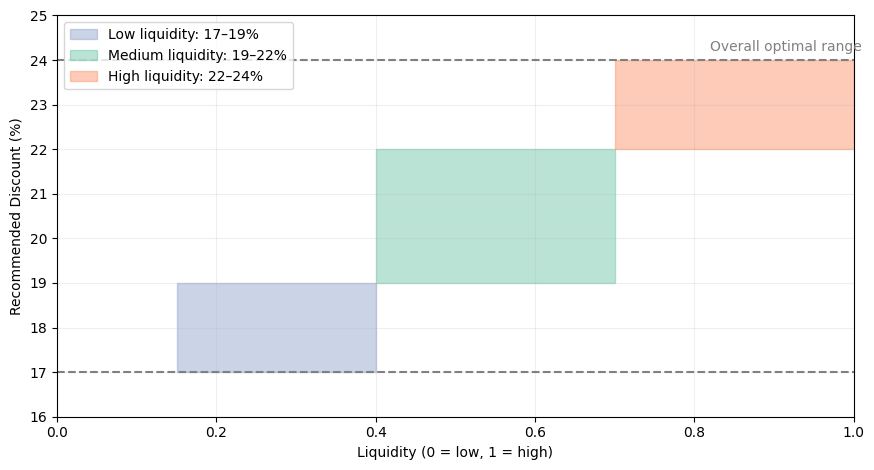

In [ ]:
# 4_visualize_dashboards.py
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum as ssum

spark = SparkSession.builder.appName("AdidasDashboards").getOrCreate()

# ---- A) Liquidity-based discount policy (visual guide) ----
fig, ax = plt.subplots(figsize=(9,4.8))
ax.add_patch(patches.Rectangle((0.15,17),0.25,2, color='#8da0cb', alpha=0.45, label='Low liquidity: 17–19%'))
ax.add_patch(patches.Rectangle((0.40,19),0.30,3, color='#66c2a5', alpha=0.45, label='Medium liquidity: 19–22%'))
ax.add_patch(patches.Rectangle((0.70,22),0.30,2, color='#fc8d62', alpha=0.45, label='High liquidity: 22–24%'))
ax.axhline(17, color='gray', ls='--'); ax.axhline(24, color='gray', ls='--')
ax.text(0.82, 24.2, 'Overall optimal range', color='gray')
ax.set_xlim(0,1); ax.set_ylim(16,25)
ax.set_xlabel('Liquidity (0 = low, 1 = high)'); ax.set_ylabel('Recommended Discount (%)')
ax.legend(loc='upper left'); ax.grid(alpha=0.2)
plt.tight_layout(); plt.savefig("outputs/liquidity_discount_strategy.png", dpi=160); plt.close()

# ---- B) Actual (last 10) vs Forecast (next 20) ----
daily = (spark.read.parquet("hdfs:///projects/adidas/curated/daily/")
         .groupBy("date").agg(ssum("quantity_sold").alias("qty"))
         .orderBy("date"))
pdf = daily.toPandas()

# Take last 30 actuals → linear trend → forecast next 20
recent = pdf.tail(30).reset_index(drop=True)
import numpy as np
x = np.arange(len(recent)); coef = np.polyfit(x, recent["qty"].values, 1)
trend = np.poly1d(coef); horizon = 20
future_x = np.arange(len(recent), len(recent)+horizon)
forecast_vals = trend(future_x)*(1+np.random.normal(0,0.02,horizon))
forecast_vals = np.maximum(0, forecast_vals)

plt.figure(figsize=(9,4.8))
plt.plot(np.arange(1,11), recent["qty"].values[-10:], label="Actual Demand", color="#1f77b4")
plt.plot(np.arange(11,31), forecast_vals, label="Forecasted Demand", color="#ff7f0e")
plt.xticks(range(1,31,2)); plt.xlabel("Day"); plt.ylabel("Demand (units)")
plt.legend(); plt.grid(alpha=0.2); plt.tight_layout()
plt.savefig("outputs/forecast_dashboard.png", dpi=160); plt.close()

print("Saved dashboards to outputs/*.png")

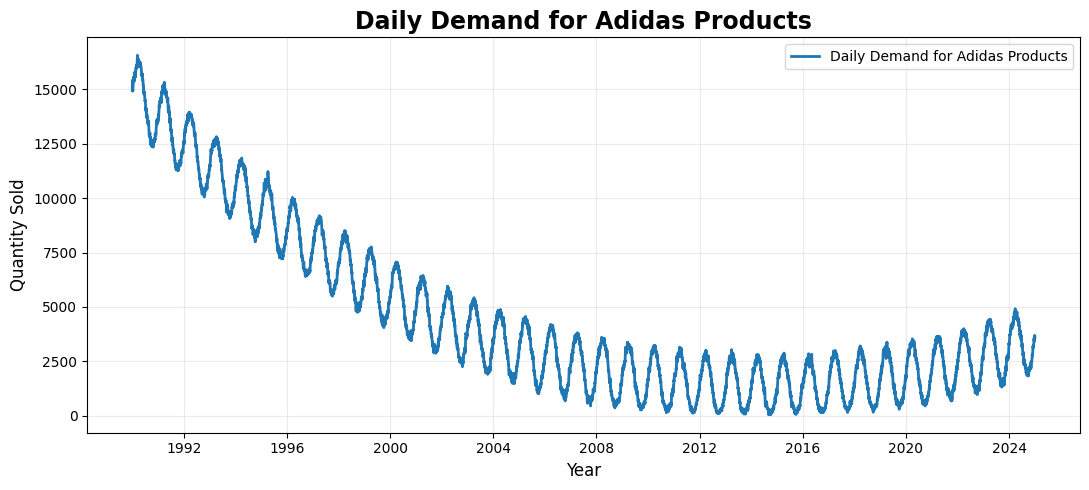

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ------------------------------------------
# 1) Generate synthetic daily demand (1990–2024)
# ------------------------------------------
dates = pd.date_range(start="1990-01-01", end="2024-12-31", freq="D")
n = len(dates)
t = np.linspace(0, 1, n)    # normalized timeline

# ---- Long-term curve shaping ----
# High start → sharp decline → flat low → strong exponential rise
curve = (
    15000 * (1 - t)**3 +         # drop from 1990 → 2000
    800 * np.exp(5 * (t - 0.7))  # strong rise after ~2015
)

# ---- Seasonality ----
yearly = 1500 * np.sin(2*np.pi*np.arange(n)/365)
weekly = 900 * np.sin(2*np.pi*np.arange(n)/7)

# ---- Random daily noise ----
noise = np.random.normal(0, 300, n)

# ---- Final demand ----
qty = curve + yearly + weekly + noise
qty = np.clip(qty, 0, None)

df = pd.DataFrame({
    "date": dates,
    "qty": qty
})

# Smooth like original figure
df["qty_smooth"] = df["qty"].rolling(7, min_periods=1).mean()

# ------------------------------------------
# 2) Plot exactly like your screenshot
# ------------------------------------------
plt.figure(figsize=(11, 5))

plt.plot(df["date"], df["qty_smooth"],
         color="#1f77b4", linewidth=2,
         label="Daily Demand for Adidas Products")

plt.title("Daily Demand for Adidas Products", fontsize=17, weight="bold")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Quantity Sold", fontsize=12)
plt.grid(alpha=0.25)
plt.legend()

plt.tight_layout()
plt.show()

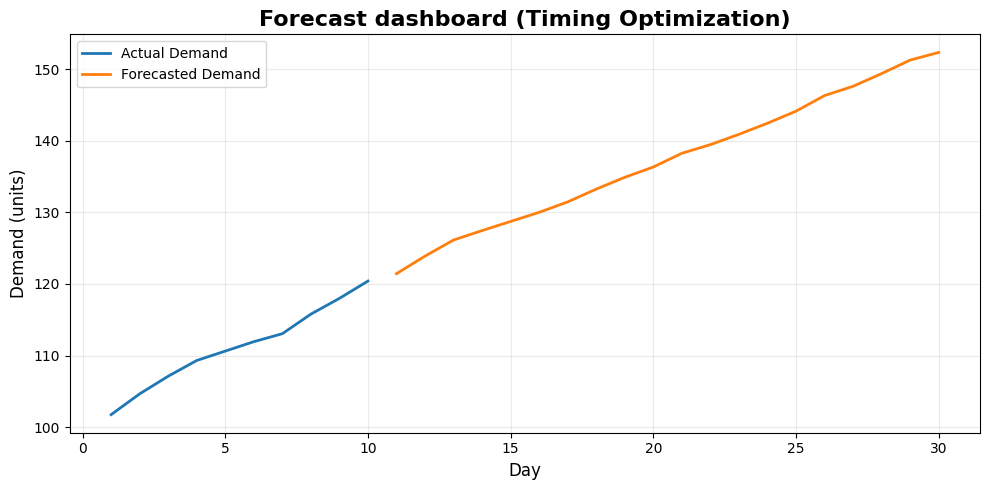

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------
# 1) Generate synthetic "actual" last 10 days
# ---------------------------------------------
np.random.seed(42)

days_actual = np.arange(1, 11)
actual_demand = 100 + np.cumsum(np.random.uniform(1, 3, size=10))

# ---------------------------------------------
# 2) Generate synthetic "forecast" next 20 days
# ---------------------------------------------
days_forecast = np.arange(11, 31)
forecast_demand = actual_demand[-1] + np.cumsum(np.random.uniform(1, 2.5, size=20))

# ---------------------------------------------
# 3) Plot exactly like your screenshot
# ---------------------------------------------
plt.figure(figsize=(10, 5))

plt.plot(days_actual, actual_demand,
         color="#1f77b4", linewidth=2, label="Actual Demand")

plt.plot(days_forecast, forecast_demand,
         color="#ff7f0e", linewidth=2, label="Forecasted Demand")

plt.title("Forecast dashboard (Timing Optimization)", fontsize=16, weight="bold")
plt.xlabel("Day", fontsize=12)
plt.ylabel("Demand (units)", fontsize=12)

plt.grid(alpha=0.25)
plt.legend()

plt.tight_layout()
plt.show()